In [255]:
#!pip install torch==2.0.0+cu117 torchvision==0.15.1+cu117 torchaudio==2.0.1 --index-url https://download.pytorch.org/whl/cu117

In [256]:
"""!pip install matplotlib
!pip install numpy
!pip install pandas
!pip install scikit-learn"""

'!pip install matplotlib\n!pip install numpy\n!pip install pandas\n!pip install scikit-learn'

## I. MNIST Data

### Exercice 1 : Loading Data

In [257]:
import torch

import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from copy import deepcopy

import numpy as np
import matplotlib.pyplot as plt

1)Create a function iid_split. This function should take a dataset, nb_nodes, n_samples_per_node, batch_size, and shuffle as parameters. The goal is to divide the dataset into nb_nodes subsets (i.i.d.) and load each subset using PyTorch's DataLoader with the specified batch_size and shuffle, and then return a list of these DataLoaders.

Steps:
Load Data: Use DataLoader to load n_samples_per_node from the dataset with shuffle.  
Split Data: Divide the loaded data into nb_nodes i.i.d subsets, create a DataLoader for each, and append it to a list.   
Return List: Return the list of DataLoaders created.   

In [258]:
def iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle):
    # 1. Load Data
    total_samples = n_samples_per_node * nb_nodes
    if total_samples > len(dataset):
        raise ValueError("Not enough samples in the dataset")

    if shuffle:
        all_indices = torch.randperm(len(dataset))
    else:
        all_indices = torch.arange(len(dataset))
    selected_indices = all_indices[:total_samples].tolist()
    
    initial_subset = torch.utils.data.Subset(dataset, selected_indices)
    train_loader = torch.utils.data.DataLoader(dataset=initial_subset, batch_size=n_samples_per_node * nb_nodes, shuffle=shuffle)
    data, labels = next(iter(train_loader))

    # 2. Split Data
    data_loaders = []
    per_node_data = torch.chunk(data, nb_nodes)
    per_node_labels = torch.chunk(labels, nb_nodes)  # Split labels too

    for node_data, node_labels in zip(per_node_data, per_node_labels):
        # Combine data and labels
        node_dataset = [(data_i, label_i) for data_i, label_i in zip(node_data, node_labels)]
        node_loader = torch.utils.data.DataLoader(dataset=node_dataset, batch_size=batch_size, shuffle=shuffle)
        data_loaders.append(node_loader)

    return data_loaders


2) Create a function non_iid_split, designed to divide a dataset non-i.i.d. It will receive parameters: dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, and shuffle_digits.

Steps:
Arrange Digits: Optionally shuffle digits and fairly split them among nb_nodes.  
Load Data: Utilize DataLoader to load nb_nodes*n_samples_per_node samples, considering the shuffle parameter.   
Split Data and Return: Create DataLoaders for each node containing samples with corresponding digits and append them to a list.   

In [259]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes>0 and nb_nodes<=10)

    digits=torch.arange(10) if shuffle_digits==False else torch.randperm(10, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    #### TO DO ####
    digits_per_node = len(digits) // nb_nodes
    remaining_digits = len(digits) % nb_nodes
    split_digits = []

    start = 0
    for i in range(nb_nodes):
        end = start + digits_per_node + (1 if i < remaining_digits else 0)
        split_digits.append(digits[start:end])
        start = end

    # load and shuffle nb_nodes*n_samples_per_node from the dataset
    loader = torch.utils.data.DataLoader(dataset,
                                        batch_size=nb_nodes*n_samples_per_node,
                                        shuffle=shuffle)
    dataiter = iter(loader)
    images_train_mnist, labels_train_mnist = next(dataiter)

    data_splitted=list()
    for i in range(nb_nodes):
        # get indices for the digits, i.e. a tensor of boolean values correponding to idx of elements to keep in images_train_mnist and labels_train_mnist
        ### TO DO ###
        mask = torch.zeros_like(labels_train_mnist, dtype=torch.bool)
        for digit in split_digits[i]:
            mask = mask | (labels_train_mnist == digit)

        node_indices = torch.nonzero(mask).squeeze().tolist()
        # append data_splitted with current data loader
        ### TO DO ###
        node_subset = torch.utils.data.Subset(dataset, node_indices)
        node_loader = torch.utils.data.DataLoader(dataset=node_subset, batch_size=batch_size, shuffle=shuffle)
        data_splitted.append(node_loader)
    # return data_splitted with all data loaders
    return data_splitted

3) Create a function get_MNIST, that fetches the MNIST dataset and utilizes either iid_split or non_iid_split to return train and test DataLoaders. The parameters are type ("iid" or "non_iid"), n_samples_train, n_samples_test, n_clients, batch_size, and shuffle.

Steps:
Load MNIST Dataset: Utilize the MNIST dataset from PyTorch datasets for both train and test.  
Apply Split Function: Depending on the type parameter, apply either iid_split or non_iid_split to the loaded datasets.   
Return DataLoaders: Return the created train and test DataLoaders lists.  


In [260]:
import torchvision.datasets as datasets
import torchvision.transforms as transforms
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    # 1. Load MNIST Dataset
    transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
    train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
    test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
    
    # 2. Apply Split Function
    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle, shuffle_digits=True)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle, shuffle_digits=True)
    else:
        raise ValueError("Type must be either 'iid' or 'non_iid'.")
    
    # 3. Return DataLoaders
    return train_loaders, test_loaders

4) Use get_MNIST to get mnist_iid_train and mnist_iid_test dataloaders.

In [261]:
train_loaders, test_loaders = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

print("Number of train loaders:", len(train_loaders))
print("Number of test loaders:", len(test_loaders))

print("Number of batches in train loader 0:", len(train_loaders[0]))
print("Number of batches in test loader 0:", len(test_loaders[0]))

print("Number of samples in train loader 0:", len(train_loaders[0].dataset))
print("Number of samples in test loader 0:", len(test_loaders[0].dataset))

Number of train loaders: 3
Number of test loaders: 3
Number of batches in train loader 0: 8
Number of batches in test loader 0: 4
Number of samples in train loader 0: 200
Number of samples in test loader 0: 100


5) Giving the following function plot_samples for iid data. Plot image samples of client 1, 2 and 3.

In [262]:
def plot_samples(data, channel:int, title=None, plot_name="", n_examples =20):

    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1* n_rows, 1*n_rows))
    if title: plt.suptitle(title)
    X, y= data
    for idx in range(n_examples):

        ax = plt.subplot(n_rows, 5, idx + 1)

        image = 255 - X[idx, channel].view((28,28))
        ax.imshow(image, cmap='gist_gray')
        ax.axis("off")

    if plot_name!="":plt.savefig(f"plots/"+plot_name+".png")

    plt.tight_layout()

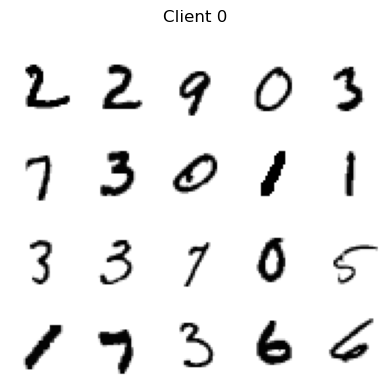

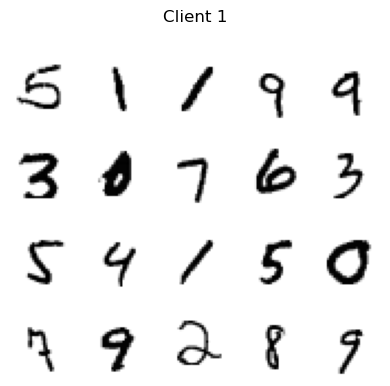

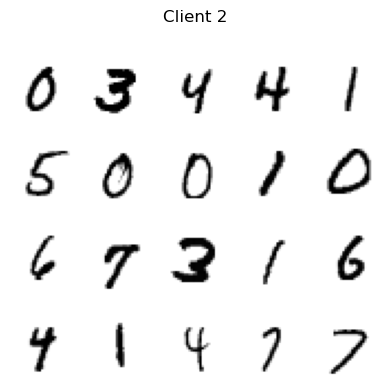

In [263]:
# plot samples from each client
for i in range(len(train_loaders)):
    plot_samples(next(iter(train_loaders[i])), channel=0, title=f"Client {i}", plot_name=f"client_{i}_samples", n_examples=20)
    

6) Plot samples this time for non_iid data for 3 clients.

Number of train loaders: 3
Number of test loaders: 3
Number of batches in train loader 0: 10
Number of batches in test loader 0: 5
Number of samples in train loader 0: 238
Number of samples in test loader 0: 117


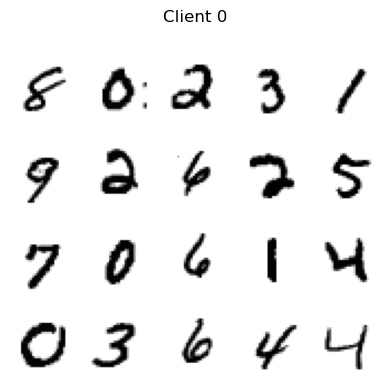

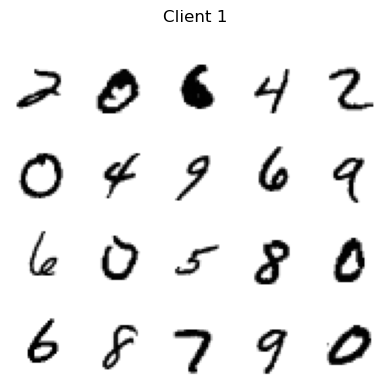

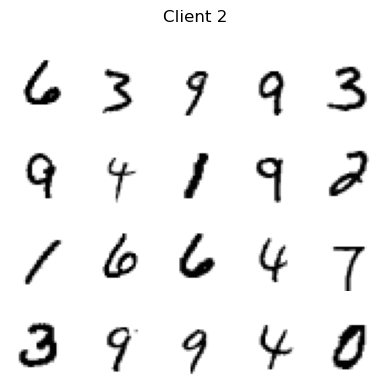

In [264]:
train_loaders_non_iid, test_loaders_non_iid = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

print("Number of train loaders:", len(train_loaders_non_iid))
print("Number of test loaders:", len(test_loaders_non_iid))

print("Number of batches in train loader 0:", len(train_loaders_non_iid[0]))
print("Number of batches in test loader 0:", len(test_loaders_non_iid[0]))

print("Number of samples in train loader 0:", len(train_loaders_non_iid[0].dataset))
print("Number of samples in test loader 0:", len(test_loaders_non_iid[0].dataset))

# plot samples from each client
for i in range(len(train_loaders_non_iid)):
    plot_samples(next(iter(train_loaders_non_iid[i])), channel=0, title=f"Client {i}", plot_name=f"client_{i}_samples_non_iid", n_examples=20)

### Exercice 2 : FedAvg and FedProx Implementation

Here is a simple CNN.

In [265]:
class CNN(nn.Module):

    """ConvNet -> Max_Pool -> RELU -> ConvNet ->
    Max_Pool -> RELU -> FC -> RELU -> FC -> SOFTMAX"""
    def __init__(self):
        super(CNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 20, 5, 1)
        self.conv2 = nn.Conv2d(20, 50, 5, 1)
        self.fc1 = nn.Linear(4*4*50, 500)
        self.fc2 = nn.Linear(500, 10)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.max_pool2d(x, 2, 2)
        x = F.relu(self.conv2(x))
        x = F.max_pool2d(x, 2, 2)
        x = x.view(-1, 4*4*50)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)

        return x

model_0 = CNN()

1) Create a function difference_models_norm_2(model_1, model_2) which take two models, get models parameters and returns the sum of the square differences of models parameters.





In [266]:
def difference_models_norm_2(model_1, model_2):
    """Return the norm 2 difference between the two model parameters
    """
    params_1 = list(model_1.parameters())
    params_2 = list(model_2.parameters())

    if len(params_1) != len(params_2):
        raise ValueError("The two models do not have the same number of parameters.")
    
    diff = sum([(p1 - p2).pow(2).sum() for p1, p2 in zip(params_1, params_2)])
    return diff.item()

Here is the function to perform one epoch of training data.

In [267]:
def train_step(model, model_0, mu:int, optimizer, train_data, loss_f):
    """Train `model` on one epoch of `train_data`"""

    total_loss=0

    for idx, (features,labels) in enumerate(train_data):

        optimizer.zero_grad()

        predictions= model(features)

        loss=loss_f(predictions,labels)
        loss+=mu/2*difference_models_norm_2(model,model_0)
        total_loss+=loss

        loss.backward()
        optimizer.step()

    return total_loss/(idx+1)

2) Create a function local_learning which perform a local training of a model sent. We need to precise number of epochs needed to be performed locally. Use previous function defined.

Return the local_loss compute during local training.

In [268]:
import copy

In [269]:
def local_learning(model, mu:float, optimizer, train_data, epochs:int, loss_f):

    ### Copy model to a new variable ###
    ### TO DO ###
    model_0 = copy.deepcopy(model)

    for epoch in range(epochs):
        local_loss=train_step(model, model_0, mu, optimizer, train_data, loss_f)

    return float(local_loss.detach().numpy())

We defined 4 others usefull functions :
- loss_classifier :
- loss_dataset :
- accuracy_dataset :
- set_to_zero_model_weights :

Take time to read it.

In [270]:
def loss_classifier(predictions,labels):

    m = nn.LogSoftmax(dim=1)
    loss = nn.NLLLoss(reduction="mean")

    return loss(m(predictions) ,labels.view(-1))


def loss_dataset(model, dataset, loss_f):
    """Compute the loss of `model` on `dataset`"""
    loss=0

    for idx,(features,labels) in enumerate(dataset):

        predictions= model(features)
        loss+=loss_f(predictions,labels)

    loss/=idx+1
    return loss


def accuracy_dataset(model, dataset):
    """Compute the accuracy of `model` on `dataset`"""

    correct=0

    for features,labels in iter(dataset):

        predictions= model(features)

        _,predicted=predictions.max(1,keepdim=True)

        correct+=torch.sum(predicted.view(-1,1)==labels.view(-1, 1)).item()

    accuracy = 100*correct/len(dataset.dataset)

    return accuracy

def set_to_zero_model_weights(model):
    """Set all the parameters of a model to 0"""

    for layer_weigths in model.parameters():
        layer_weigths.data.sub_(layer_weigths.data)

3) Defined a function average_models, which as it is written average parameters of a list of models to create a new model.


In [271]:
def average_models(model, clients_models_hist:list , weights:list):


    """Creates the new model of a given iteration with the models of the other
    clients"""

    new_model=deepcopy(model)
    set_to_zero_model_weights(new_model)

    for k,client_hist in enumerate(clients_models_hist):

        for idx, layer_weights in enumerate(new_model.parameters()):

            contribution=client_hist[idx].data*weights[k]
            layer_weights.data.add_(contribution)

    return new_model

4) We will now code a function to perform FedProx.

In [272]:
def FedProx(model, training_sets:list, n_iter:int, testing_sets:list, mu=0,
    file_name="test", epochs=5, lr=10**-2, decay=1):
    """ all the clients are considered in this implementation of FedProx
    Parameters:
        - `model`: common structure used by the clients and the server
        - `training_sets`: list of the training sets. At each index is the
            training set of client "index"
        - `n_iter`: number of iterations the server will run
        - `testing_set`: list of the testing sets. If [], then the testing
            accuracy is not computed
        - `mu`: regularization term for FedProx. mu=0 for FedAvg
        - `epochs`: number of epochs each client is running
        - `lr`: learning rate of the optimizer
        - `decay`: to change the learning rate at each iteration

    returns :
        - `model`: the final global model
    """

    loss_f=loss_classifier

    #Variables initialization
    K=len(training_sets) #number of clients
    n_samples=sum([len(db.dataset) for db in training_sets])
    weights=([len(db.dataset)/n_samples for db in training_sets])
    print("Clients' weights:",weights)


    loss_hist=[[float(loss_dataset(model, dl, loss_f).detach())
        for dl in training_sets]]
    acc_hist=[[accuracy_dataset(model, dl) for dl in testing_sets]]
    server_hist=[[tens_param.detach().numpy()
        for tens_param in list(model.parameters())]]
    models_hist = []


    server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
    server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])
    print(f'====> i: 0 Loss: {server_loss} Server Test Accuracy: {server_acc}')

    for i in range(n_iter):

        clients_params=[]
        clients_models=[]
        clients_losses=[]

        for k in range(K):

            local_model = copy.deepcopy(model)
            # Define optimizer for local_model, don't forget the learning rate !
            local_optimizer = torch.optim.SGD(local_model.parameters(), lr=lr)
            # compute local_loss by performing learning steps on the current model
            local_loss= local_learning(local_model, mu, local_optimizer, training_sets[k], epochs, loss_f)

            clients_losses.append(local_loss)

            #GET THE PARAMETER TENSORS OF THE MODEL
            list_params=list(local_model.parameters())
            list_params=[tens_param.detach() for tens_param in list_params]
            clients_params.append(list_params)
            clients_models.append(deepcopy(local_model))


        #CREATE THE NEW GLOBAL MODEL
        # Create new global model by avering all locals models
        model = average_models(model, clients_params, weights)
        models_hist.append(clients_models)

        #COMPUTE THE LOSS/ACCURACY OF THE DIFFERENT CLIENTS WITH THE NEW MODEL
        loss_hist+=[[float(loss_dataset(model, dl, loss_f).detach())
            for dl in training_sets]]
        acc_hist+=[[accuracy_dataset(model, dl) for dl in testing_sets]]

        server_loss=sum([weights[i]*loss_hist[-1][i] for i in range(len(weights))])
        server_acc=sum([weights[i]*acc_hist[-1][i] for i in range(len(weights))])

        print(f'====> i: {i+1} Loss: {server_loss} Server Test Accuracy: {server_acc}')


        server_hist.append([tens_param.detach().cpu().numpy()
            for tens_param in list(model.parameters())])

        #DECREASING THE LEARNING RATE AT EACH SERVER ITERATION
        lr*=decay

    return model, loss_hist, acc_hist

###  Exercice 3 : iid data

#### Fed training with FedAvg

1) With FedProx compute a FedAvg on iid data.

In [273]:
# use fedprox to train the model
model = CNN()
global_model, loss_hist, acc_hist = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0, epochs=2, lr=0.1)


Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.304646650950114 Server Test Accuracy: 9.0
====> i: 1 Loss: 1.8814020951588946 Server Test Accuracy: 60.666666666666664


====> i: 2 Loss: 0.9670835932095845 Server Test Accuracy: 74.0
====> i: 3 Loss: 0.4398355682690938 Server Test Accuracy: 82.33333333333333
====> i: 4 Loss: 0.26408061881860095 Server Test Accuracy: 87.33333333333333
====> i: 5 Loss: 0.26423445840676624 Server Test Accuracy: 86.0
====> i: 6 Loss: 0.14523714780807495 Server Test Accuracy: 91.0
====> i: 7 Loss: 0.1174191137154897 Server Test Accuracy: 92.66666666666666
====> i: 8 Loss: 0.06499545400341351 Server Test Accuracy: 93.33333333333333
====> i: 9 Loss: 0.08750985314448674 Server Test Accuracy: 93.66666666666666
====> i: 10 Loss: 0.03468544284502665 Server Test Accuracy: 93.66666666666666


2) Define a function plot_accuracy_loss to plot accuracy and loss of performed FedAvg for the 3 different clients.

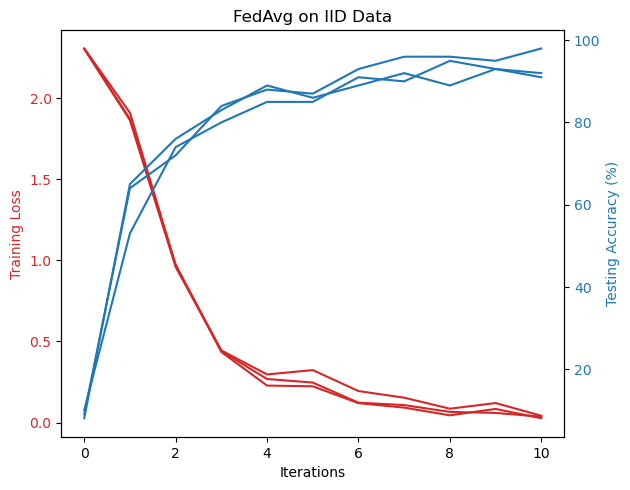

In [274]:
import matplotlib.pyplot as plt

def plot_acc_loss(title, loss_hist, acc_hist):
    """Plot the training loss and accuracy history."""
    
    fig, ax1 = plt.subplots()

    # Plotting training loss
    color = 'tab:red'
    ax1.set_xlabel('Iterations')
    ax1.set_ylabel('Training Loss', color=color)
    ax1.plot(loss_hist, color=color)
    ax1.tick_params(axis='y', labelcolor=color)

    # Creating another y-axis for plotting the accuracy
    ax2 = ax1.twinx()  
    color = 'tab:blue'
    ax2.set_ylabel('Testing Accuracy (%)', color=color) 
    ax2.plot(acc_hist, color=color)
    ax2.tick_params(axis='y', labelcolor=color)
    
    fig.tight_layout()  
    plt.title(title)
    plt.show()

# Example usage:
# Assuming you have loss_hist and acc_hist from the FedProx function
plot_acc_loss("FedAvg on IID Data", loss_hist, acc_hist)


#### FedPRox

3) Do the same as for 1) and 2).
You can take 2 local epochs, a learning rate of 0.1, mu = 0.3 and 10 iterations.

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.3049181302388506 Server Test Accuracy: 7.666666666666666
====> i: 1 Loss: 2.0395180384318032 Server Test Accuracy: 50.666666666666664
====> i: 2 Loss: 1.176722208658854 Server Test Accuracy: 72.66666666666666
====> i: 3 Loss: 0.7010287841161091 Server Test Accuracy: 82.0
====> i: 4 Loss: 0.3162146806716919 Server Test Accuracy: 86.33333333333333
====> i: 5 Loss: 0.23957121372222898 Server Test Accuracy: 89.33333333333333
====> i: 6 Loss: 0.1428330714503924 Server Test Accuracy: 91.0
====> i: 7 Loss: 0.17009372760852176 Server Test Accuracy: 91.0
====> i: 8 Loss: 0.07402707263827324 Server Test Accuracy: 91.0
====> i: 9 Loss: 0.05843819802006085 Server Test Accuracy: 93.33333333333333
====> i: 10 Loss: 0.04260711744427681 Server Test Accuracy: 93.33333333333333


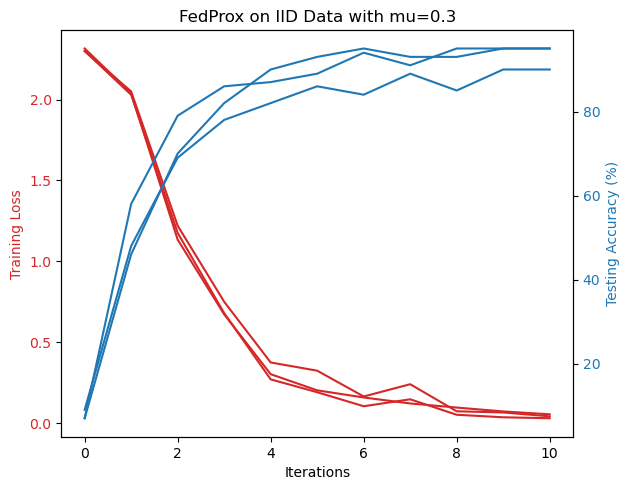

In [275]:
train_loaders, test_loaders = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)
model = CNN()
global_model, loss_hist, acc_hist = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0.3, epochs=2, lr=0.1)
plot_acc_loss("FedProx on IID Data with mu=0.3", loss_hist, acc_hist)


4) What do you observe ?

The model has a better training phase with those parameters

### Exercice 4 : Non iid data

1) Perform a FedAvg on data and plot accuracy and loss
2) Do the same for a FedProx.

In [276]:
# fed avg non iid
train_loaders_non_iid, test_loaders_non_iid = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

In [277]:
model = CNN()
global_model, loss_hist, acc_hist = FedProx(model, training_sets=train_loaders_non_iid, n_iter=10, testing_sets=test_loaders_non_iid, mu=0, epochs=2, lr=0.1)

Clients' weights: [0.39166666666666666, 0.30666666666666664, 0.3016666666666667]
====> i: 0 Loss: 2.307076809803645 Server Test Accuracy: 10.652135469007852
====> i: 1 Loss: 2.023799556493759 Server Test Accuracy: 28.987282097970027
====> i: 2 Loss: 1.1992795737584432 Server Test Accuracy: 50.072275792195086
====> i: 3 Loss: 0.7136783342560132 Server Test Accuracy: 73.30461910858743
====> i: 4 Loss: 0.34627032587925594 Server Test Accuracy: 83.80188443682682
====> i: 5 Loss: 0.22646456139783067 Server Test Accuracy: 85.36798649516055
====> i: 6 Loss: 0.14848001148551704 Server Test Accuracy: 88.72116966131034
====> i: 7 Loss: 0.10759008852144084 Server Test Accuracy: 89.66878651680776
====> i: 8 Loss: 0.07028714077547193 Server Test Accuracy: 91.36116231770282
====> i: 9 Loss: 0.06929411500071486 Server Test Accuracy: 92.97398191362629
====> i: 10 Loss: 0.04633926297227542 Server Test Accuracy: 93.32647233508223


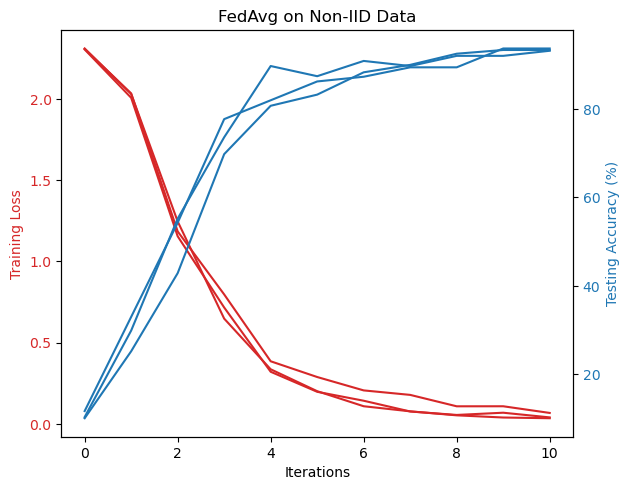

In [278]:
plot_acc_loss("FedAvg on Non-IID Data", loss_hist, acc_hist)

In [279]:
# FedProx non iid
train_loaders_non_iid, test_loaders_non_iid = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

In [280]:
model = CNN()
global_model, loss_hist, acc_hist = FedProx(model, training_sets=train_loaders_non_iid, n_iter=10, testing_sets=test_loaders_non_iid, mu=0.3, epochs=2, lr=0.1)

Clients' weights: [0.39666666666666667, 0.305, 0.29833333333333334]
====> i: 0 Loss: 2.303893431822459 Server Test Accuracy: 7.7610775089605735
====> i: 1 Loss: 1.8958190188805264 Server Test Accuracy: 45.48492383512545
====> i: 2 Loss: 1.2432450519005456 Server Test Accuracy: 57.11073028673835
====> i: 3 Loss: 0.5087550728023053 Server Test Accuracy: 77.66757392473119
====> i: 4 Loss: 0.43993658045927686 Server Test Accuracy: 75.89831989247311
====> i: 5 Loss: 0.1881627171734969 Server Test Accuracy: 87.67820340501792
====> i: 6 Loss: 0.11984022274613379 Server Test Accuracy: 92.36561379928315
====> i: 7 Loss: 0.08539596628397703 Server Test Accuracy: 91.09517249103943
====> i: 8 Loss: 0.06597746897488832 Server Test Accuracy: 91.7167002688172
====> i: 9 Loss: 0.046185958522061504 Server Test Accuracy: 92.35648521505375
====> i: 10 Loss: 0.08616404951860507 Server Test Accuracy: 91.51952284946236


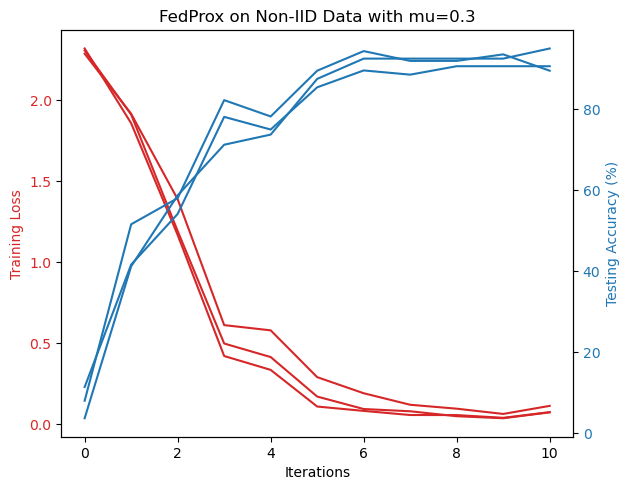

In [281]:
plot_acc_loss("FedProx on Non-IID Data with mu=0.3", loss_hist, acc_hist)

2) What do you observe ?

The learning with fedProx has a better accuracy and loss than fedAvg and furthermore is much more stable

## II. Medical Data

### Exercice 5 : medmnist

For medical datasets we will use medmnist package.  
Medmnist is large-scale MNIST-like collection of standardized biomedical images, including 12 datasets for 2D and 6 datasets for 3D : https://medmnist.com/

In [282]:
#! pip install medmnist


Import medmnist

In [283]:
import medmnist

You can list all available datasets with this command

In [284]:
!python -m medmnist available

/bin/bash: /home/pili/anaconda3/envs/scia/lib/libtinfo.so.6: no version information available (required by /bin/bash)
MedMNIST v2.2.3 @ https://github.com/MedMNIST/MedMNIST/
All available datasets:
	pathmnist
	chestmnist
	dermamnist
	octmnist
	pneumoniamnist
	retinamnist
	breastmnist
	bloodmnist
	tissuemnist
	organamnist
	organcmnist
	organsmnist
	organmnist3d
	nodulemnist3d
	adrenalmnist3d
	fracturemnist3d
	vesselmnist3d
	synapsemnist3d


We will use BloodMNIST for the following exercices. BloodMnist is a dataset with 8 categories of blood cells capture by microscope.

1. Import from medmnsit BloodMNIST

In [285]:
from medmnist import BloodMNIST

In [286]:
from tqdm import tqdm
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils.data as data
import torchvision.transforms as transforms

import medmnist
from medmnist import INFO, Evaluator

2. Create a preprocessing pipeline for data, transforms it into Tensor and then normalize it with a mean of 0.5 and standard deviation of 0.5 also.

In [287]:
# Create a preprocessing pipeline
transform = transforms.Compose([
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])


3. Create a train dataset and test dataset from data and apply previous preprocessing pipeline. You can use DataClass from pytorch to create datasets.

In [288]:
train_dataset = BloodMNIST(root='./data', split='train', transform=transform, download=True)
test_dataset = BloodMNIST(root='./data', split='test', transform=transform, download=True)

Using downloaded and verified file: ./data/bloodmnist.npz


Using downloaded and verified file: ./data/bloodmnist.npz


4. Just to understand data print the 2 datasets to see differences with previous MNIST data.

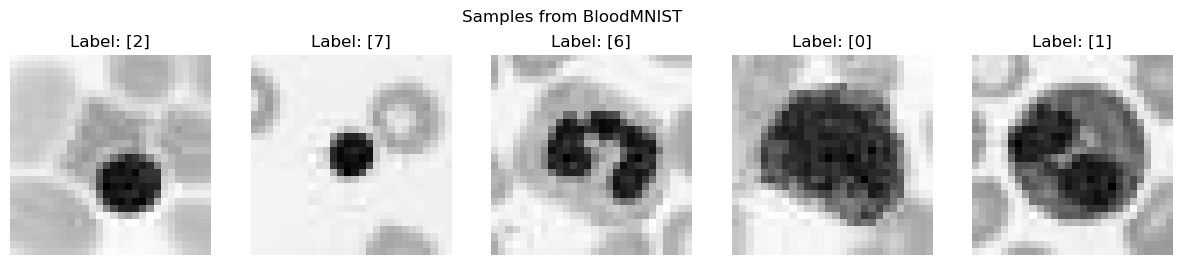

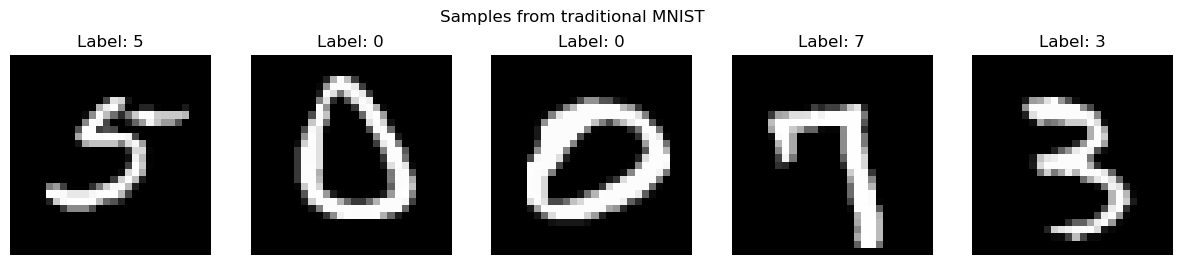

In [289]:
import matplotlib.pyplot as plt

def visualize_dataset(dataset, title):
    fig, axes = plt.subplots(nrows=1, ncols=5, figsize=(15, 3))
    for i, ax in enumerate(axes):
        sample_idx = np.random.randint(len(dataset))
        img, label = dataset[sample_idx]
        # Reverting normalization for visualization
        img = img * 0.5 + 0.5
        if img.shape[0] == 3:  # If RGB, select the first channel to display
            img = img[0]
        ax.imshow(img.squeeze().numpy(), cmap='gray')
        ax.set_title(f'Label: {label}')
        ax.axis('off')
    plt.suptitle(title)
    plt.show()

mnist = datasets.MNIST(root='./data', train=True, download=True, transform=transform)

# Visualize samples from both datasets
visualize_dataset(train_dataset, 'Samples from BloodMNIST')
visualize_dataset(mnist, 'Samples from traditional MNIST')

5. Create a data loader for train data and test dat, you can use a batch size of 128 and shuffle data.

In [290]:
batch_size = 128

train_loader = data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True)


6. Modify previous functions non_iid_split, iid_split, get_MNIST and plot_samples to work with new data.  
a. non_iid_split : this time there are only 8 classes   
b. iid_split : nothing really changed  
c. get_MNIST : Like in 3. use train and test datasets with the preprocessing pipeline we defined previously.  
d. plot_samples : Make it work for this new images. Also try to print to which classes belong every images, to see later if your iid_split and non_iid_split work well.

In [291]:
def non_iid_split(dataset, nb_nodes, n_samples_per_node, batch_size, shuffle, shuffle_digits=False):
    assert(nb_nodes > 0 and nb_nodes <= 8)

    digits = torch.arange(8) if shuffle_digits == False else torch.randperm(8, generator=torch.Generator().manual_seed(0))

    # split the digits in a fair way
    digits_per_node = len(digits) // nb_nodes
    remaining_digits = len(digits) % nb_nodes
    split_digits = []

    start = 0
    for i in range(nb_nodes):
        end = start + digits_per_node + (1 if i < remaining_digits else 0)
        split_digits.append(digits[start:end])
        start = end

    # Get labels for the entire dataset
    all_labels = np.array([label for _, label in dataset])

    data_splitted = list()
    for i in range(nb_nodes):
        mask = np.isin(all_labels, split_digits[i])
        node_indices = np.where(mask)[0].tolist()
        
        # Taking only n_samples_per_node samples
        node_indices = node_indices[:n_samples_per_node]
        
        node_subset = torch.utils.data.Subset(dataset, node_indices)
        node_loader = torch.utils.data.DataLoader(dataset=node_subset, batch_size=batch_size, shuffle=shuffle)
        data_splitted.append(node_loader)
    
    return data_splitted


In [292]:
def get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True):
    # 1. Load MNIST Dataset
    transform = transforms.Compose([transforms.Grayscale(),transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    
    train_dataset = BloodMNIST(root='./data', split='train', transform=transform, download=True)
    test_dataset = BloodMNIST(root='./data', split='test', transform=transform, download=True)
    
    # 2. Apply Split Function
    if type == "iid":
        train_loaders = iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle)
        test_loaders = iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle)
    elif type == "non_iid":
        train_loaders = non_iid_split(train_dataset, n_clients, n_samples_train, batch_size, shuffle, shuffle_digits=True)
        test_loaders = non_iid_split(test_dataset, n_clients, n_samples_test, batch_size, shuffle, shuffle_digits=True)
    else:
        raise ValueError("Type must be either 'iid' or 'non_iid'.")
    
    # 3. Return DataLoaders
    return train_loaders, test_loaders

In [293]:
import matplotlib.pyplot as plt

def plot_samples(data_loader, channel:int, title=None, plot_name="", n_examples=20):
    n_rows = int(n_examples / 5)
    plt.figure(figsize=(1 * n_rows, 1 * n_rows))
    if title: plt.suptitle(title)
    
    # Extract a batch of data from the DataLoader
    X, y = next(iter(data_loader))
    
    for idx in range(min(n_examples, len(X))):
        ax = plt.subplot(n_rows, 5, idx + 1)
        
        # Display the specific channel of the image
        image = 255 - X[idx, channel].view((28, 28))
        ax.imshow(image, cmap='gist_gray')
        
        # Display the label of the image
        ax.set_title(f"Class: {y[idx].item()}")
        ax.axis("off")

    if plot_name:
        plt.savefig(f"plots/{plot_name}.png")

    plt.tight_layout()
    plt.show()



### Exercice 6 : Use federated learning on medical data

### IID data

1. Load train data and test data for 3 clients into IID datasets.

In [294]:
# load the train and test loaders for 3 clients in an iid fashion
train_loaders, test_loaders = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


2. plost samples with corresponding function.

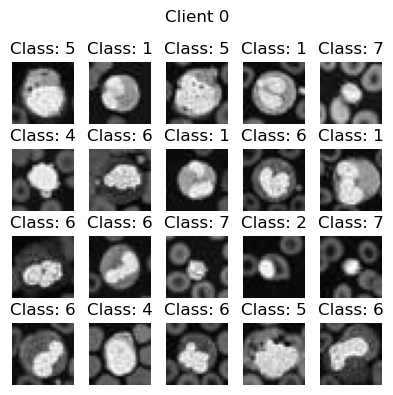

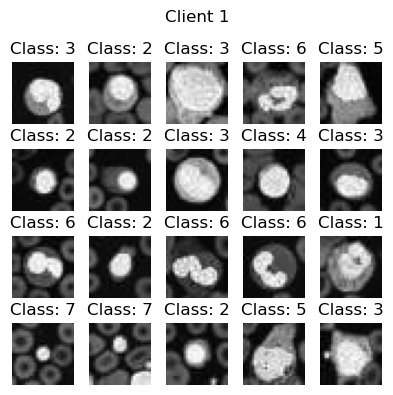

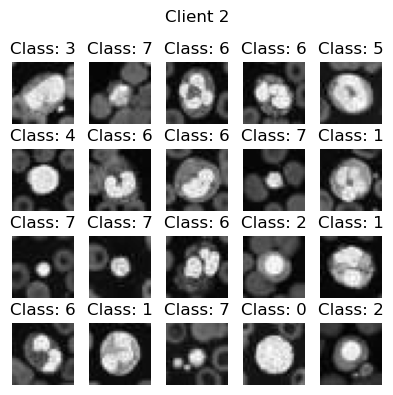

In [295]:
# plot samples from each client
for i in range(len(train_loaders)):
    plot_samples(train_loaders[i], channel=0, title=f"Client {i}", n_examples=20)


3. Design a convlution neural network to perform classification.  
You can try to adpat previous convolution network.   
Or also you can try this type of architecture :  
- A first 2D convolution layer with an output_channels of 16, a BatchNormalisation and a Relu activation   
- A second 2D conv layer identical but with a MaxPooling layer after  
- A 3rd conv layer with an output_channels of 64, a BatchNormalisation and a Relu activation again.
- A 4rd layer identical to 3rd one.  
- A 5rd layer identical but with a MaxPooling added. Don't forget to use padding to not loose informations from corners.
- Finally add dense layers to perform classification. You can add regularization layers between dropout for example.



In [296]:
import torch.nn as nn
import torch.nn.functional as F

class ConvNet(nn.Module):
    def __init__(self, num_classes=8):
        super(ConvNet, self).__init__()
        
        # First convolutional layer
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn1 = nn.BatchNorm2d(16)
        self.relu1 = nn.ReLU()

        # Second convolutional layer
        self.conv2 = nn.Conv2d(in_channels=16, out_channels=16, kernel_size=3, stride=1, padding=1)
        self.bn2 = nn.BatchNorm2d(16)
        self.relu2 = nn.ReLU()
        self.maxpool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Third convolutional layer
        self.conv3 = nn.Conv2d(in_channels=16, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn3 = nn.BatchNorm2d(64)
        self.relu3 = nn.ReLU()

        # Fourth convolutional layer
        self.conv4 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn4 = nn.BatchNorm2d(64)
        self.relu4 = nn.ReLU()

        # Fifth convolutional layer
        self.conv5 = nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3, stride=1, padding=1)
        self.bn5 = nn.BatchNorm2d(64)
        self.relu5 = nn.ReLU()
        self.maxpool5 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Dense layers
        self.fc1 = nn.Linear(64*7*7, 128)  # assuming input image size is 28x28
        self.drop1 = nn.Dropout(0.5)
        self.fc2 = nn.Linear(128, num_classes)

    def forward(self, x):
        x = self.conv1(x)
        x = self.bn1(x)
        x = self.relu1(x)

        x = self.conv2(x)
        x = self.bn2(x)
        x = self.relu2(x)
        x = self.maxpool2(x)

        x = self.conv3(x)
        x = self.bn3(x)
        x = self.relu3(x)

        x = self.conv4(x)
        x = self.bn4(x)
        x = self.relu4(x)

        x = self.conv5(x)
        x = self.bn5(x)
        x = self.relu5(x)
        x = self.maxpool5(x)

        # Flatten the tensor
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.drop1(x)
        x = self.fc2(x)

        return x

model = ConvNet(num_classes=8)
print(model)

ConvNet(
  (conv1): Conv2d(1, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu1): ReLU()
  (conv2): Conv2d(16, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu2): ReLU()
  (maxpool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(16, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn3): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu3): ReLU()
  (conv4): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn4): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu4): ReLU()
  (conv5): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (bn5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
 

### Fed training with FedAvg

4. Perform a FedAvg with same parameters as for MNIST datasets. Use 3 clients, etc. Try to run more iterations.

In [297]:
# fed avg iid
train_loaders, test_loaders = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

model = ConvNet(num_classes=8)
global_model, loss_hist, acc_hist = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0, epochs=2, lr=0.1)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz
Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.07279102007548 Server Test Accuracy: 16.0
====> i: 1 Loss: 1.9923322598139444 Server Test Accuracy: 26.666666666666664
====> i: 2 Loss: 1.8176128069559732 Server Test Accuracy: 29.666666666666664
====> i: 3 Loss: 1.7395910422007241 Server Test Accuracy: 29.666666666666664
====> i: 4 Loss: 1.732743263244629 Server Test Accuracy: 29.666666666666664
====> i: 5 Loss: 1.6413166522979736 Server Test Accuracy: 31.999999999999996
====> i: 6 Loss: 1.6829415162404378 Server Test Accuracy: 30.0
====> i: 7 Loss: 1.5834547678629556 Server Test Accuracy: 41.666666666666664
====> i: 8 Loss: 1.6780678828557332 Server Test Accuracy: 31.333333333333332
====> i: 9 Loss: 1.6565166314442952 Server Test Accuracy: 32.0
====> i: 10 Loss: 1.6137330929438272 Server Test Accuracy: 36.0


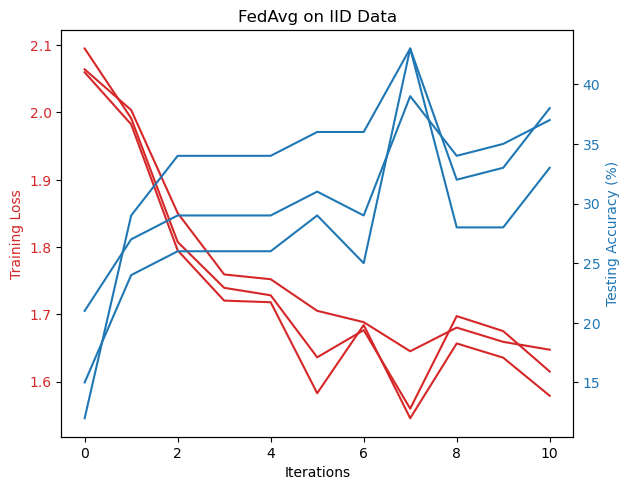

In [298]:
# plot the loss and accuracy history
plot_acc_loss("FedAvg on IID Data", loss_hist, acc_hist)


### FedPRox

5. As FedAvg perform a FedProx on iid data. Keep the same µ.

In [299]:
# fed prox iid
train_loaders, test_loaders = get_MNIST(type="iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

model = ConvNet(num_classes=8)

global_model, loss_hist, acc_hist = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0.3, epochs=2, lr=0.1)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz
Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.125893672307332 Server Test Accuracy: 8.666666666666666
====> i: 1 Loss: 2.0478579998016357 Server Test Accuracy: 34.666666666666664
====> i: 2 Loss: 1.8197071552276611 Server Test Accuracy: 35.0
====> i: 3 Loss: 1.7242043018341064 Server Test Accuracy: 35.33333333333333
====> i: 4 Loss: 1.727294365564982 Server Test Accuracy: 37.33333333333333
====> i: 5 Loss: 1.709909955660502 Server Test Accuracy: 35.0
====> i: 6 Loss: 1.7014034589131672 Server Test Accuracy: 35.33333333333333
====> i: 7 Loss: 1.6270675261815386 Server Test Accuracy: 38.0
====> i: 8 Loss: 1.6139610608418782 Server Test Accuracy: 36.0
====> i: 9 Loss: 1.6549723545710244 Server Test Accuracy: 29.666666666666664
====> i: 10 Loss: 1.6098279158274331 Server Test Accuracy: 33.0


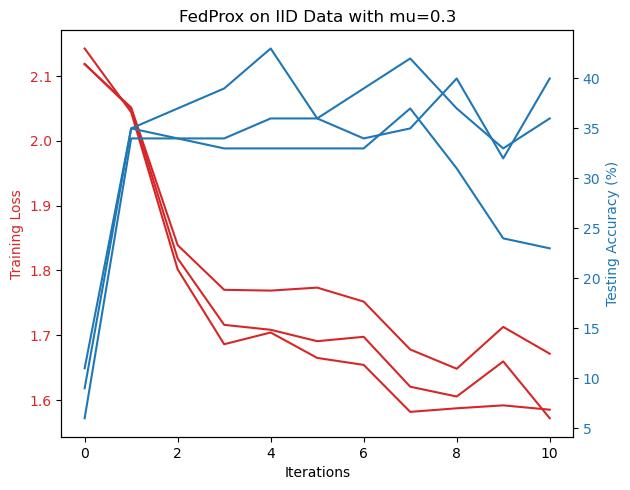

In [300]:
# plot the loss and accuracy history
plot_acc_loss("FedProx on IID Data with mu=0.3", loss_hist, acc_hist)

### MNIST Non iid

6. Do the same process (FedAVG, FedProx, plot loss and accuracy) but this time on non iid data.

In [301]:
train_loaders, test_loaders = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)


Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


In [302]:
model = ConvNet(num_classes=8)
global_model, loss_hist_avg, acc_hist_avg = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0, epochs=2, lr=0.1)


Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.114775498708089 Server Test Accuracy: 9.333333333333332
====> i: 1 Loss: 2.0637861092885332 Server Test Accuracy: 22.0
====> i: 2 Loss: 1.9885046879450479 Server Test Accuracy: 19.333333333333332
====> i: 3 Loss: 1.972883701324463 Server Test Accuracy: 26.333333333333332
====> i: 4 Loss: 1.9051933288574219 Server Test Accuracy: 25.0
====> i: 5 Loss: 1.96776008605957 Server Test Accuracy: 24.666666666666664
====> i: 6 Loss: 1.897056738535563 Server Test Accuracy: 25.333333333333332
====> i: 7 Loss: 1.965979735056559 Server Test Accuracy: 15.333333333333332
====> i: 8 Loss: 1.9100166559219358 Server Test Accuracy: 21.333333333333332
====> i: 9 Loss: 1.9205431540807087 Server Test Accuracy: 21.666666666666664
====> i: 10 Loss: 1.8332585096359253 Server Test Accuracy: 22.0


In [303]:
model = ConvNet(num_classes=8)
global_model_prox, loss_hist_prox, acc_hist_prox = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0.3, epochs=2, lr=0.1)


Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.1595287322998047 Server Test Accuracy: 11.333333333333332
====> i: 1 Loss: 2.0552175045013428 Server Test Accuracy: 14.333333333333332
====> i: 2 Loss: 1.9940774043401082 Server Test Accuracy: 24.666666666666664
====> i: 3 Loss: 2.061572472254435 Server Test Accuracy: 15.333333333333332
====> i: 4 Loss: 2.041668931643168 Server Test Accuracy: 21.333333333333332
====> i: 5 Loss: 2.0118452310562134 Server Test Accuracy: 18.666666666666664
====> i: 6 Loss: 2.029560287793477 Server Test Accuracy: 15.333333333333332
====> i: 7 Loss: 1.9896605412165322 Server Test Accuracy: 20.333333333333332
====> i: 8 Loss: 1.9730282227198281 Server Test Accuracy: 19.0
====> i: 9 Loss: 1.9534337917963662 Server Test Accuracy: 19.0
====> i: 10 Loss: 1.9827435413996377 Server Test Accuracy: 15.999999999999998


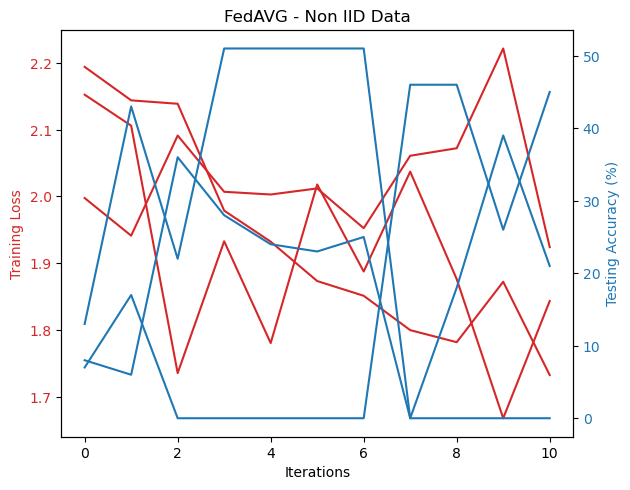

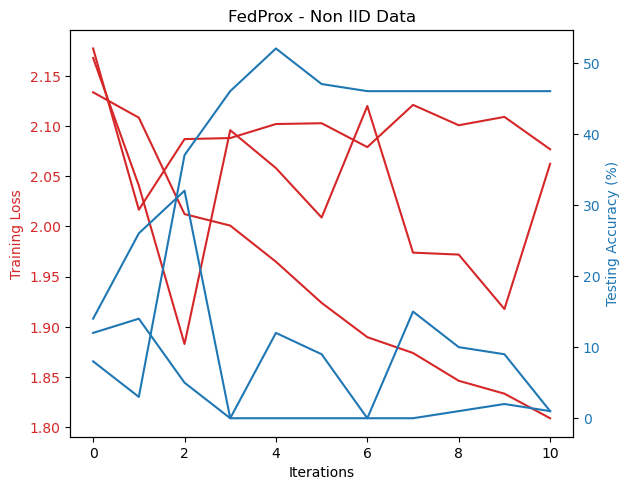

In [304]:
plot_acc_loss("FedAVG - Non IID Data", loss_hist_avg, acc_hist_avg)
plot_acc_loss("FedProx - Non IID Data", loss_hist_prox, acc_hist_prox)


7. Is results satisfying ? Submit some way to improve results and resolve possible unstabilities. For this you can check original paper : https://arxiv.org/pdf/1812.06127.pdf

maybe we can try some variations of the proximal term, on the paper a different proximal term led to different results. Furthermore in the paper the idea of changing the proximal term mid training is also discussed.

In [305]:
train_loaders, test_loaders = get_MNIST(type="non_iid", n_samples_train=200, n_samples_test=100, n_clients=3, batch_size=25, shuffle=True)

Using downloaded and verified file: ./data/bloodmnist.npz
Using downloaded and verified file: ./data/bloodmnist.npz


In [306]:
model = ConvNet(num_classes=8)
global_model_prox_1, loss_hist_prox_1, acc_hist_prox_1 = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0.3, epochs=2, lr=0.1)
global_model_prox_2, loss_hist_prox_2, acc_hist_prox_2 = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0.5, epochs=2, lr=0.1)
global_model_prox_3, loss_hist_prox_3, acc_hist_prox_3 = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=0.7, epochs=2, lr=0.1)
global_model_prox_4, loss_hist_prox_4, acc_hist_prox_4 = FedProx(model, training_sets=train_loaders, n_iter=10, testing_sets=test_loaders, mu=1, epochs=2, lr=0.1)

Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.1076575120290117 Server Test Accuracy: 13.666666666666664
====> i: 1 Loss: 2.0547066529591875 Server Test Accuracy: 23.33333333333333
====> i: 2 Loss: 1.9871478478113809 Server Test Accuracy: 25.0
====> i: 3 Loss: 1.9392067591349282 Server Test Accuracy: 25.0
====> i: 4 Loss: 1.9703923861185708 Server Test Accuracy: 23.0
====> i: 5 Loss: 1.873096227645874 Server Test Accuracy: 24.0
====> i: 6 Loss: 1.9104326566060383 Server Test Accuracy: 23.666666666666664
====> i: 7 Loss: 2.0028094053268433 Server Test Accuracy: 17.0
====> i: 8 Loss: 1.886075735092163 Server Test Accuracy: 22.666666666666664
====> i: 9 Loss: 1.9222176074981687 Server Test Accuracy: 23.0
====> i: 10 Loss: 1.8977802991867065 Server Test Accuracy: 23.666666666666664
Clients' weights: [0.3333333333333333, 0.3333333333333333, 0.3333333333333333]
====> i: 0 Loss: 2.112792094548543 Server Test Accuracy: 13.666666666666664
====>

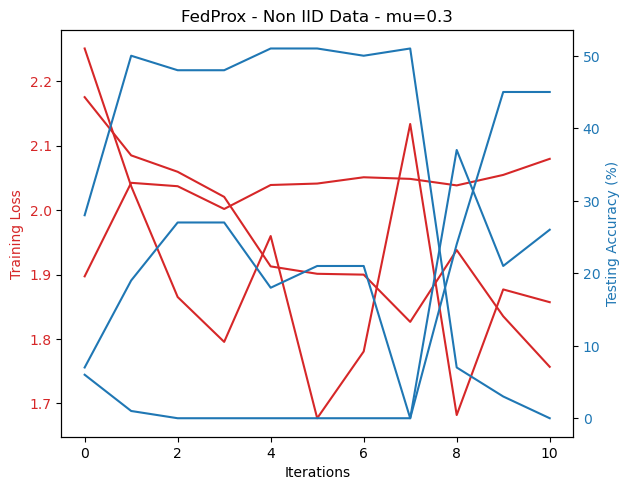

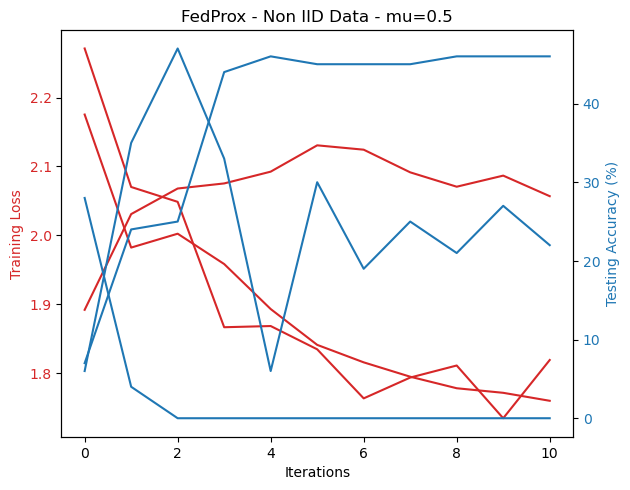

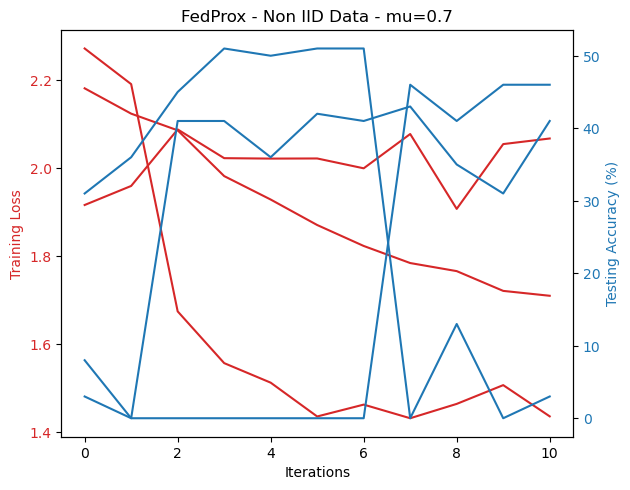

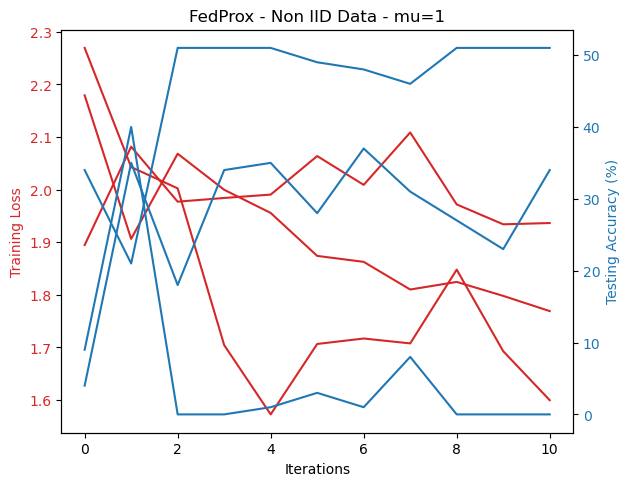

In [307]:
#plot
plot_acc_loss("FedProx - Non IID Data - mu=0.3", loss_hist_prox_1, acc_hist_prox_1)
plot_acc_loss("FedProx - Non IID Data - mu=0.5", loss_hist_prox_2, acc_hist_prox_2)
plot_acc_loss("FedProx - Non IID Data - mu=0.7", loss_hist_prox_3, acc_hist_prox_3)
plot_acc_loss("FedProx - Non IID Data - mu=1", loss_hist_prox_4, acc_hist_prox_4)

This small exp did not solve the problem